In [25]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from utils.custom_dataset import GTSRBCustomDataset
from models.cnn_model import CNNModel
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [26]:
BATCH_SIZE = 32
EPOCHS = 10
CSV_PATH = "dataset/Train.csv"
ROOT_DIR = "dataset"

In [27]:
print("Checking files...")
if not os.path.exists(CSV_PATH):
  raise FileNotFoundError(f"CSV file not found: {CSV_PATH}")
if not os.path.exists(ROOT_DIR):
  raise FileNotFoundError(f"Root directory not found: {ROOT_DIR}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Checking files...
Using device: cuda


In [28]:
transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.RandomRotation(10),
  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [29]:
print("Creating dataset...")
train_dataset = GTSRBCustomDataset(CSV_PATH, ROOT_DIR, transform=transform)
print(f"Dataset size: {len(train_dataset)}")

Creating dataset...
Loading CSV from: dataset/Train.csv
Dataset loaded: 39209 samples
Columns: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']
Validating image paths...
✓ Image 1 exists: Train/20/00020_00000_00000.png
✓ Image 2 exists: Train/20/00020_00000_00001.png
✓ Image 3 exists: Train/20/00020_00000_00002.png
✓ Image 4 exists: Train/20/00020_00000_00003.png
✓ Image 5 exists: Train/20/00020_00000_00004.png
✓ Image 6 exists: Train/20/00020_00000_00005.png
✓ Image 7 exists: Train/20/00020_00000_00006.png
✓ Image 8 exists: Train/20/00020_00000_00007.png
✓ Image 9 exists: Train/20/00020_00000_00008.png
✓ Image 10 exists: Train/20/00020_00000_00009.png
Dataset size: 39209


Testing dataset loading...
Sample loaded successfully - Image shape: torch.Size([3, 64, 64]), Label: 20


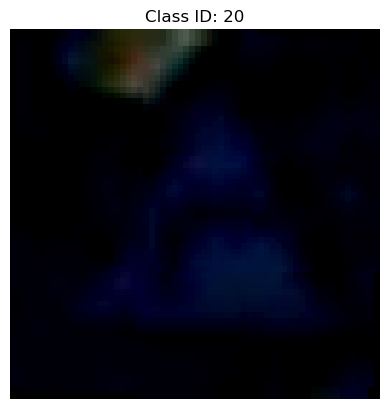

In [30]:
print("Testing dataset loading...")
try:
  sample_image, sample_label = train_dataset[0]
  print(f"Sample loaded successfully - Image shape: {sample_image.shape}, Label: {sample_label}")
  
  image_np = sample_image.permute(1, 2, 0).numpy()
  image_np = (image_np * 0.5 + 0.5).clip(0, 1)

  plt.imshow(image_np)
  plt.title(f"Class ID: {sample_label}")
  plt.axis('off')
  plt.show()

except Exception as e:
  print(f"Error loading sample: {e}")
  exit(1)

In [31]:
train_loader = DataLoader(
  train_dataset, 
  batch_size=BATCH_SIZE, 
  shuffle=True, 
  num_workers=0,
  pin_memory=True if device.type == 'cuda' else False
)

In [32]:
print("Testing batch loading...")
try:
  for batch_images, batch_labels in train_loader:
    print(f"Batch loaded successfully - Batch shape: {batch_images.shape}")
    break
except Exception as e:
  print(f"Error loading batch: {e}")
  exit(1)

Testing batch loading...
Batch loaded successfully - Batch shape: torch.Size([32, 3, 64, 64])


In [33]:
print("Loading model...")
model = CNNModel(num_classes=43).to(device)
print(f"Model loaded on {device}")

Loading model...
Model loaded on cuda


In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [35]:
os.makedirs("outputs/checkpoints", exist_ok=True)

In [36]:
print("Starting training...")
for epoch in range(EPOCHS):
  model.train()
  total_loss = 0
  correct = 0
  batch_count = 0
  total_samples = 0

  print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")
  
  progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}", ncols=100)

  for batch_idx, (images, labels) in progress_bar:
    try:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()
      correct += (outputs.argmax(1) == labels).sum().item()
      total_samples += images.size(0)
      batch_count += 1

      current_loss = loss.item()
      current_acc = correct / total_samples

      progress_bar.set_postfix(loss=f"{current_loss:.4f}", acc=f"{current_acc:.4f}")

    except Exception as e:
      print(f"Error in batch {batch_idx}: {e}")
      continue

  if batch_count > 0:
    avg_loss = total_loss / batch_count
    acc = correct / len(train_dataset)
    print(f"{epoch + 1}/{EPOCHS} - Loss: {avg_loss:.4f} - Acc: {acc:.4f}")
  else:
    print(f"{epoch + 1}/{EPOCHS} - No valid batches processed")

Starting training...

--- Epoch 1/10 ---


Epoch 1: 100%|█████████████████████████| 1226/1226 [00:58<00:00, 20.79it/s, acc=0.8244, loss=0.1361]


1/10 - Loss: 0.6379 - Acc: 0.8244

--- Epoch 2/10 ---


Epoch 2: 100%|█████████████████████████| 1226/1226 [00:58<00:00, 21.01it/s, acc=0.9550, loss=0.1062]


2/10 - Loss: 0.1582 - Acc: 0.9550

--- Epoch 3/10 ---


Epoch 3: 100%|█████████████████████████| 1226/1226 [00:57<00:00, 21.31it/s, acc=0.9691, loss=0.0027]


3/10 - Loss: 0.1066 - Acc: 0.9691

--- Epoch 4/10 ---


Epoch 4: 100%|█████████████████████████| 1226/1226 [00:58<00:00, 21.06it/s, acc=0.9739, loss=0.1270]


4/10 - Loss: 0.0872 - Acc: 0.9739

--- Epoch 5/10 ---


Epoch 5: 100%|█████████████████████████| 1226/1226 [00:59<00:00, 20.61it/s, acc=0.9770, loss=0.0104]


5/10 - Loss: 0.0818 - Acc: 0.9770

--- Epoch 6/10 ---


Epoch 6: 100%|█████████████████████████| 1226/1226 [00:58<00:00, 20.98it/s, acc=0.9818, loss=0.0093]


6/10 - Loss: 0.0633 - Acc: 0.9818

--- Epoch 7/10 ---


Epoch 7: 100%|█████████████████████████| 1226/1226 [00:58<00:00, 20.97it/s, acc=0.9821, loss=0.0000]


7/10 - Loss: 0.0640 - Acc: 0.9821

--- Epoch 8/10 ---


Epoch 8: 100%|█████████████████████████| 1226/1226 [00:58<00:00, 21.07it/s, acc=0.9837, loss=0.0000]


8/10 - Loss: 0.0560 - Acc: 0.9837

--- Epoch 9/10 ---


Epoch 9: 100%|█████████████████████████| 1226/1226 [00:57<00:00, 21.24it/s, acc=0.9817, loss=0.0000]


9/10 - Loss: 0.0596 - Acc: 0.9817

--- Epoch 10/10 ---


Epoch 10: 100%|████████████████████████| 1226/1226 [00:57<00:00, 21.18it/s, acc=0.9866, loss=0.0107]

10/10 - Loss: 0.0460 - Acc: 0.9866


In [37]:
print("Saving model...")
torch.save(model.state_dict(), "outputs/checkpoints/cnn.pth")

Saving model...


In [38]:
print("CNN Model saved at outputs/checkpoints/cnn.pth")

CNN Model saved at outputs/checkpoints/cnn.pth
